# 泰坦尼克号生还者预测

1912年4月15日，在首次航行期间，泰坦尼克号撞上冰山后沉没，2224名乘客和机组人员中有1502人遇难。这场悲剧轰动了国际社会。沉船导致遇难的原因之一是没有足够的救生艇给乘客和船员。虽然在这场灾难中幸存下来有一些运气在里面，但一些人比其他人更有可能幸存，比如妇女，儿童和上层阶级。

在本次案例中，我们会使用机器学习方法对哪些人更有可能生还作出预测。

## 数据介绍

survival - 是否幸存（0=幸存，1=遇难）   
pclass - 船票类型（1=一等票，2=二等票，3=三等票）   
sex - 性别   
age - 年龄   
sibsp - 泰坦尼克号上该人员兄弟姐妹的数量   
parch - 泰坦尼克好上该人员父母或者子女的数量   
ticket - 船票编号   
fare - 乘客票价   
cabin - 客舱号码   
embarked - 起航运港（C = Cherbourg, Q = Queenstown, S = Southampton）   
boat - 救生艇的编号（如果幸存）   
body - 人体编号（如果遇难并且尸体被找到）   
home.dest - 出发地到目的地

## 数据分析

导入pandas、numpy等基础包

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics

/Users/syoya/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


读取数据

In [2]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

In [3]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic_df['survived'].mean()

0.3819709702062643

计算显示只有38%左右的乘客幸存下来，这次惨剧发生的原因是泰坦尼克号上并未携带足够的救生艇，只有20艘，这对于1317名乘客和885名机组人员来说还远远不够。我们接下来会按照乘客的阶级地位对数据进行分析：

In [5]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


我们可以看出来头等舱对乘客有62%的生还几率，相比之下三等舱对乘客只有25.5%的生还概率，此外客舱越豪华，乘客的年纪也就越大，同时一等票票价明显高于二三等票。   
我们继续按照阶级和性别研究数据：

In [6]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

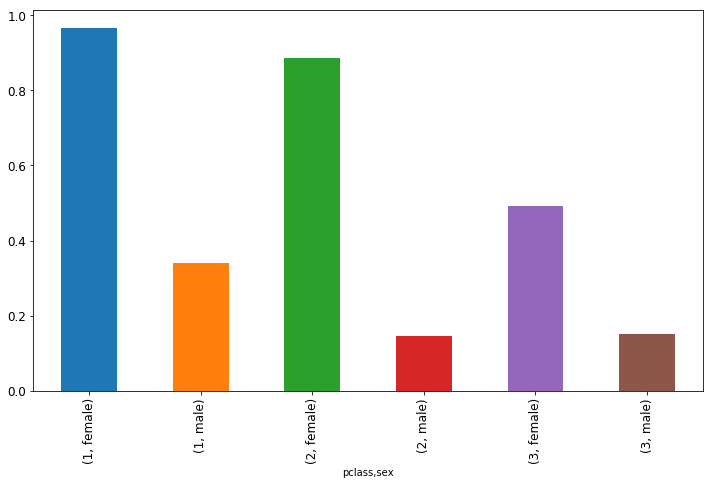

In [7]:
class_sex_grouping['survived'].plot.bar(figsize=(12, 7), fontsize=12)

从上面的分析中可以看出来，在惨剧发生的时候大家倾向于首先疏散妇女和儿童。在所有的阶层中，女性比男性更有可能生存下来。

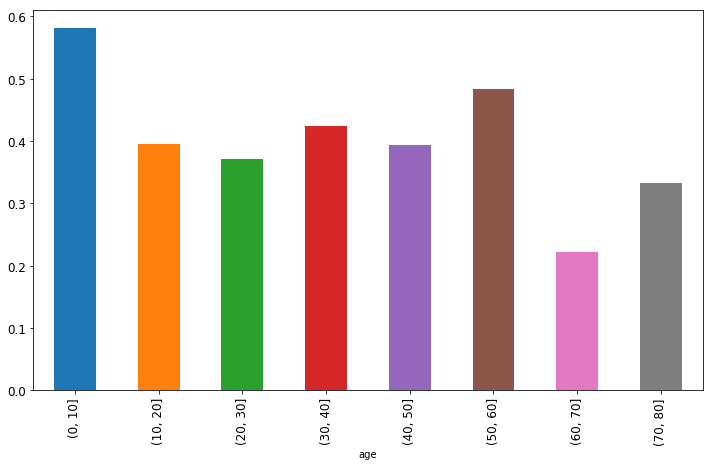

In [8]:
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar(figsize=(12, 7), fontsize=12)

上面的柱状图表示了儿童中生还的比例是最高的。

## 数据处理

In [9]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


在构建机器学习模型前我们需要删除填充缺失值并且将数据集分为训练集和测试集。

In [10]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

我们选择删除掉boat、cabin、body这三个缺失值较多而且无法提供足够信息的字段

In [11]:
titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)

另外还有很多行缺少“home.dest”字段，我们用“NA”值填充缺失的部分。

In [12]:
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")

In [13]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
embarked     1307 non-null object
home.dest    1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


同时我们可以看出来age字段也有一部分数据缺少，因为年龄对于乘客能不能生还会产生较大的影响，所以我们选择删除年龄字段缺失的那部分数据。

In [14]:
titanic_df = titanic_df.dropna()

在做了上述处理后我们重新统计下数据。

In [15]:
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [16]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"


sex和embarked都是与类别（比如sex有两种值，male和female）对应的字符串值，因此通过LabelEncoder我们可以将类别字符串分别转换数值数据，比如将“male”和“female”转换成0和1。name、ticket、home.dest字段无法做编码转换成数值数据，所以我们从数据集中删除掉它们。

In [17]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    # 将sex（性别）和embarked（起航运港）做编码，从字符串转换成机器学习模型可以识别的数字数据
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    # 删除掉name、ticket、home.dest字段
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

In [18]:
processed_df = preprocess_titanic_df(titanic_df)

In [19]:
processed_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29.0000,0,0,211.3375,2
1,1,1,1,0.9167,1,2,151.5500,2
2,1,0,0,2.0000,1,2,151.5500,2
3,1,0,1,30.0000,1,2,151.5500,2
4,1,0,0,25.0000,1,2,151.5500,2


分离训练数据和目标数据，得到训练集和测试集

In [20]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

In [21]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(X_train.shape[0] / X_test.shape[0])

(834, 7)
(209, 7)
3.9904306220095696


## 机器学习

首先我们使用决策树分类器对数据进行简单的预测。

In [23]:
np.random.seed(42)

from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(max_depth=10)

In [24]:
clf_dt.fit(X_train, y_train)
clf_dt.score(X_test, y_test)

0.7894736842105263

接下来我们再用交叉验证衡量模型的具体表现能力。

In [25]:
np.random.seed(42)

shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)

def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [26]:
test_classifier(clf_dt)

Accuracy: 0.7761 (+/- 0.02)


可以看出来在交叉验证中，数据集选择的不同也会导致预测结果的不同。上述的决策树模型的平均预测准确率为77.61%，根据数据的不同可以有2%左右的浮动变化。

接下来我们再尝试下其他的模型：

In [27]:
np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier
# 随机森林分类器
clf_rf = RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7816 (+/- 0.03)


In [28]:
np.random.seed(42)
from sklearn.ensemble import GradientBoostingClassifier
# 随机森林分类器
clf_rf = GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.8201 (+/- 0.02)


不同的分类器模型在数据集上的表现不同，通常我们可以尝试不同的机器学习模型从而得到效果最好的模型。

我们还可以使用随机森林算法来获取各个不同特征在最终结果预测中的权重。

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
np.random.seed(42)
clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)

In [30]:
features = pd.DataFrame()
features['feature'] = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

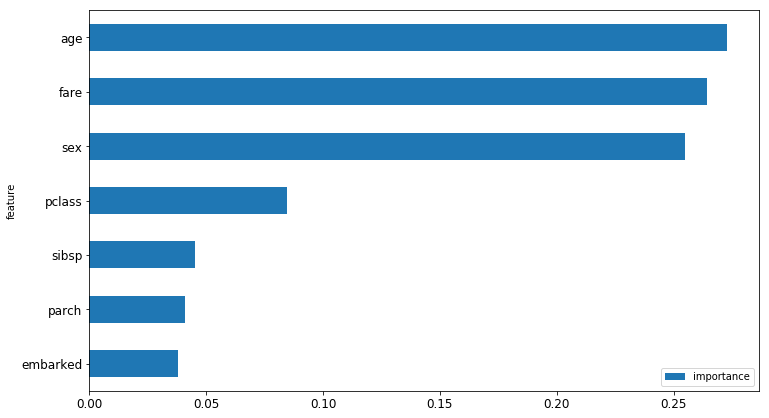

In [31]:
features.plot(kind='barh', figsize=(12, 7), fontsize=12)
plt.show()